This is a [jupyter](http://jupyter.org) notebook.

Open the notebook by (1) copying this file into a directory, (2) launching jupyter notebook in that directory
and (3) selecting the notebook.

# <u><font color= 'blue'>Analysis of the 1-D Convolution Operation </font> </u>
### <i>Practical Assignment 1, EE210 (Spring 2017) </i>
___
A notebook by ___Dhruv Ilesh Shah___ and ___Shashwat Shukla___  
___
__Required Packages:__ Python(2.7+), C++11, CUDA _(for the GPU implementations)_, NumPy, math, cmath, SciPy.io _(Optional, to simplify IO operations)_
___
In this notebook, we present an analysis of the various algorithms for computing the one-dimensional convolution operation, along with their implementation and suitable improvisations. This includes the crude implementation, parallelised implementation, Cooley-Tukey algorithm (FFT), improvised Cooley-Tukey and a vectorised FFT-based implementation. We will look at the Python and C++ implementations on both CPU and GPU.

## Motivation
The convolution operation is a fundamental operation on two functions $f$ and $g$ which produces a third function, that is typically viewed as a modified version of one of the original functions, giving the integral of the pointwise multiplication of the two functions as a function of the amount that one of the original functions is translated. Convolution is similar to _cross-correlation_.

$$
(f*g)(t) \triangleq \int_{-\infty}^{\infty} f(\tau) g(t - \tau)
$$
Where $f, g : [0, \infty) \rightarrow \mathbb{R}$.
This can be extended to discrete-time signals as
$$
(f*g)[n] \triangleq \sum_{m = -\infty}^{\infty} f[m] g[n - m]
$$

For any physical _linear & time invariant (LTI)_ system $T$, it can be shown that the output of $T$ can be represented as $y(t) = x(t) * h(t)$, where $h(t)$ represents the response of $T$ to the unit impulse. This means that given an LTI system, the complete system can be represented solely by its impulse response $h(t)$. _(Similar definition for discrete-time signals.)_

<!-- bibtex

@Article{CTmain,
Author = {James Cooley, John Tukey},
title = {An Algorithm for Machine Calculation of Complex Fourier Series},
journal = {American Mathematical Society},
year = {1965}},

@article{key ,
author = {Arthur B Cummings and David Eftekhary and Frank G House},
title = {The accurate determination of college students’
coefficients of friction},
journal = {Journal of Sketchy Physics},
volume = {13},
year = {2003},
number = {2},
pages = {46--129}
}
-->

## The Problem

Given a single-channel audio input $(16kHz)$, and the 2-channel impulse response of the surroundings as heard by the pair of human ears, generate a stereo reconstruction of the input.

$$
\begin{equation}
\begin{split}
y_l (t) &= x (t) * h_l (t) \\
y_r (t) &= x (t) * h_r (t)
\end{split}
\end{equation}
$$
***
In a typical scenario, the impulse response depends on the surroundings due to multiple reflections, interference and reverberation etc. The energy of the response, however, decays slowly and we have a finite duration response.

![Impulse Response of a Hall](Files/IR_hall.jpg)
<center>Courtesy: [ProSoundWeb](http://www.prosoundweb.com/)</center>

## Overview

As is clear from the definition, the convolution is an expensive operation and given the size of a typical sound clip $(10 sec \rightarrow 1.6\times10^5samples)$, the computation can be very intensive. But given the essentiality of the convolution as a fundamental property of an LTI system, and the immense number of applications, it cannot be ignored. Hence, we present an analysis of various ways to compute this convolution by employing certain other beautiful properties of this operation. We begin with algorithmic analysis for various methods to compute the convolution, and then go ahead to solve the actual problem with the best implementation. The topics covered are listed below:

1. __Algorithmic Overview__
    1. Naive Implementation
    2. Naive Implementation Parallelised
    3. Switching to the Frequency Domain  
          a. Naive Fourier Transform (& Vectorization)  
          b. Cooley-Tukey Algorithm  
          c. Improvising the Cooley-Tukey Algorithm 
2. __Linear and Circular Convolutions__
3. __The Final Problem__
4. __Final Remarks and The Road Ahead__

Towards the end, we use an improvised version of the _Cooley-Tukey Algorithm_ to compute the linear convolution of the given signals.

<font size=6><u> Algorithmic Overview</u></font> 


# <font color=blue> Naive Implementation </font>

Given the input signal $x(t)$ and the left-ear impulse response, say, $h_l (t)$. Then
$$
\begin{split}
y_l[n] &= x [n] *h_l[n] \\
&= \sum_{m = -\infty}^{\infty} h[m]\cdot x[n - m]
\end{split}
$$

The simplest way ahead would be to compute the above summation (smartly manipulating the limits, though) using an iterative approach. The implementation is given below.

In [42]:
import numpy as np

# Create the signals to be convolved
source = np.random.random(5000)
fir = np.random.random(5000)

def naive_convolve(x, h):
    # Declaring the resultant, and allocating memory
    y = np.zeros(len(source) + len(fir) - 1)
    for i in range(len(x)):
        for j in range(len(h)):
            y[i+j] += (x[i] * h[j])
    return y

In [44]:
%timeit naive_con = naive_convolve(source, fir)

1 loop, best of 3: 23.8 s per loop


***
Clearly, we can see that $\approx 23s$ for convoluting $5000\times5000$ is very poor indeed, and can be a major bottleneck for the various applications dependent on the convolution operation. Complexity analysis for this clearly gives the time taken to be $\mathcal{O}(m n)$, or $\mathcal{O}(n^2)$ in general.

Extending this to the required application, where we would be convoluting $200000\times70000$ terms, extending the times and accounting for overheads gives an estimate of $\approx 3.5hr$. The above code took $212min$ to give the convoluted result on the given input. Clearly, this is not acceptable. So how do we improve this algorithm?

It is not hard to see that the computations in the outer loop are independent and hence can be run as independent threads on a parallelised processor or GPU. Given infinite cores, the execution time would be $\mathcal{O}(n)$. Practical figures are much lower this mark. This is the motivation behind the next approach.
***

# <font color=blue> Naive Implementation Parallelised </font>

We note that the computations being performed tom compute the output signal at any time t don't depend in any way on the computations for any other time t'. This means that these computations can be done in parallel. Hence, given $\textbf{n}$ enough processors, we can hence perform the convolution in $\mathcal{O}(n)$ time. 

This motivates the implementation of this naive convolution algorithm on a GPU. The reason being that modern GPU have hundreds to thousands of cores, with specialised fast access cache and memory and highly optimised memory access operations and blazing fast floating point operation abilities. 

The following kernel has been written in CUDA-C++, a GPU programming language developed by Nvidia. CUDA is the leading standard for GPU computing. 

```c++
__global__ static void ConvolveCUDA(const float* a, const float* b, float* c, int n)
{
	int i = 0;

	int idx = threadIdx.x + blockDim.x * blockIdx.x;

	if (idx < n)
	{
		float t1 = 0; float t2 = 0;
		for (i = 0; i <= idx; i++) {
			t1 += a[i] * b[idx - i];
		}
		for (i = idx + 1; i < n; i++) {
			t2 += a[i] * b[n + idx - i];
		}
		c[idx] = t1;
		c[n + idx] = t2;
	}
}

clock_t convolveCUDA(const float *a, const float *b, float *c, int n)
{
	float *a_d, *b_d, *c_d;
	clock_t start, end;
	int BLOCK_NUM = n / THREAD_NUM + ((n % THREAD_NUM > 0) ? 1 : 0);

	cudaMalloc((void**)&a_d, sizeof(float) * n);
	cudaMalloc((void**)&b_d, sizeof(float) * n);
	cudaMalloc((void**)&c_d, sizeof(float) * (2 * n - 1));

	start = clock();

	cudaMemcpy(a_d, a, sizeof(float) * n, cudaMemcpyHostToDevice);
	cudaMemcpy(b_d, b, sizeof(float) * n, cudaMemcpyHostToDevice);
	cudaMemcpy(c_d, c, sizeof(float) * (2 * n - 1), cudaMemcpyHostToDevice);

	ConvolveCUDA << < BLOCK_NUM, THREAD_NUM >> >(a_d, b_d, c_d, n);

	cudaMemcpy(c, c_d, sizeof(float) * (2 * n - 1), cudaMemcpyDeviceToHost);

	end = clock();

	cudaFree(a_d);
	cudaFree(b_d);
	cudaFree(c_d);

	return end - start;
}
```
___

# <font color=blue> Switching to the Frequency Domain </font>

We saw that parallelising the algorithm to multiple cores gives a speedup of about $37.78$, but that requires a state-of-the-art GPU and a dedicated core. Looking at the enormous applications of convolution even in the simplest of games on your mobile phone, we surely need a better method to compute the convolution operation. In this section, we motivate a completely new approach that exploits the similarities between the definition of the convolution and the Fourier transform.

The __convolution theorem__ states that under suitable conditions the Fourier transform of a convolution is the pointwise product of Fourier transforms. Skipping the proof, the result can be interpreted as
$$
\begin{split}
\mathcal{F}(f*g) &= \mathcal{F}(f) \cdot \mathcal{F}(g) \\
f * g &= \mathcal{F}^{-1} \{ \mathcal{F}(f) \cdot \mathcal{F}(g) \}
\end{split}
$$
Given this bit of information, we can now approach the whole problem of convolution through this procedure.

## Algorithmic Sketch

Given the input signal $x(t)$ and response $h(t)$, we can now compute the convolution $y(t) = x(t) * h(t)$ as:

* Convert the input signal and frequency response to the frequency domain. _(Note that this step would involve intricacies like dimension of bases etc. that we will cover during the implementation)_
$$
\begin{split}
X &= \mathcal{F}(f(t)) \\
IR &= \mathcal{F}(h(t))
\end{split}
$$
* Compute the point-wise multiplication of the signals $X, IR$ in frequency domain.
$$
Y = X * IR
$$
* Compute the inverse fourier transform of $Y$ to obtain the convolved signal $y(t)$ in the time domain.
$$
y(t) = \mathcal{F}^{-1}(Y)
$$

The point-wise multiplication is a cheap step, and hence the focus of the discussion from this point will switch to the efficiency of computing the operations $\mathcal{F}$ and $\mathcal{F}^{-1}$. Let us go about this computation in different ways.

In [45]:
# For evaluating the correctness and efficiency of our algortihms, we have used NumPy as the benchmark
import numpy.fft as benchmark

# <font color=blue>Naive Fourier Transform</font>

Just like our first approach towards computing the convolution, we begin the FFT computation by the most naive of methods - the definition. An FFT computes the DFT and produces exactly the same result as evaluating the discrete Fourier transform definition directly.

Let $x_0, x_1 \dots x_{N-1}$ be complex numbers. The DFT is defined by the formula
$$
 X_k =  \sum_{n=0}^{N-1} x_n e^{-i2\pi kn/N}
\qquad
k = 0,\dots,N-1.
$$

Similar, for the inverse
$$
 x_n =  \frac{1}{N}\sum_{k=0}^{N-1} X_k e^{i2\pi kn/N}
\qquad
n = 0,\dots,N-1.
$$

The `python` implementation of this is given below.

In [46]:
import numpy as np
from cmath import exp

def naive_DFT(x):
    N = len(x)
    X = np.zeros(N, dtype=np.cfloat)
    for k in range(N):
        for n in range(N):
            X[k] += x[n] * np.exp(-2j * np.pi * k * n / N)
    return X

def naive_iDFT(X):
    N = len(X)
    x = np.zeros(N, dtype=np.cfloat)
    for n in range(N):
        for k in range(N):
            x[n] += X[k] * np.exp(2j * np.pi * k * n / N)
    return x/N

In [47]:
# Creating the input signal in time domain
signal = np.random.random(256)

signal_F = naive_DFT(signal)
L = naive_iDFT(signal_F)

In [48]:
# Checking whether the computed values are accurate (tolerance = 1e-10)
print "Validating DFT function: %s" % np.allclose(signal_F, benchmark.fft(signal), atol=1e-10)
print "Validating iDFT function: %s" % np.allclose(L, benchmark.ifft(signal_F), atol=1e-10)

Validating DFT function: True
Validating iDFT function: True


The results of the `naive_DFT` and `naive_iDFT` functions match with the results of the well-tested NumPy library and hence the code is correct. From the implementation, we can see each of the functions is $\mathcal{O}[n^2]$ and this would blow up for the large $n$ we would be using. As a demonstration:

In [49]:
test_signal = np.random.random(1024)
%timeit naive_DFT(test_signal)
%timeit benchmark.fft(test_signal)

1 loop, best of 3: 9.12 s per loop
10000 loops, best of 3: 62 µs per loop


$\approx 9s$ for a signal of $10^3$ samples would extrapolate to hours of computation time. Not acceptable, especially when we see that NumPy is doing the same operation $1.25\times 10^5x$ faster. Looking closely at the procedure, we can exploit the symmetry of the expression to reuse already computed values and speed up the computation. This is the motivation behind attempting a logarithmic-time approach for the Fourier transform.

## Vectorizing the Naive FT

Vectorization refers to the the technique of converting a series of product operations into a simpler matrix product, hence computing all the products at once. Using efficient matrix libraries, the product can be sped up by a great factor. This can be extended to our case as follows. Note that although the complexity still remains $\mathcal{O}(n^2)$, the overheads are significantly reduced and the speedup is due to the implementation, and not algorithmic.

In [50]:
import numpy as np

def vectorized_dft(x):
    # At a unit level, we compute the vectorised ifft
    x = np.asarray(x, dtype=np.cfloat)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

def vectorized_idft(x):
    # At a unit level, we compute the vectorised ifft
    x = np.asarray(x, dtype=np.cfloat)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(2j * np.pi * k * n / N)
    return np.dot(M, x) / N

In [51]:
# Creating the input signal in time domain
signal = np.random.random(256)

signal_F = vectorized_dft(signal)
L = vectorized_idft(signal_F)

In [52]:
# Checking whether the computed values are accurate (tolerance = 1e-10)
print "Validating DFT function: %s" % np.allclose(signal_F, benchmark.fft(signal), atol=1e-10)
print "Validating iDFT function: %s" % np.allclose(L, benchmark.ifft(signal_F), atol=1e-10)

Validating DFT function: True
Validating iDFT function: True


Finally, let us compare the time taken by this implementation with numpy and the our previous implementation.

In [53]:
%timeit vectorized_dft(signal)
%timeit naive_DFT(signal)
%timeit benchmark.fft(signal)

10 loops, best of 3: 19.1 ms per loop
1 loop, best of 3: 553 ms per loop
The slowest run took 10.38 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 18.2 µs per loop


Impressive, isn't it? Simply vectorizing the code can improve the runtime by a factor of 30! This makes vectorization a very important trick while writing codes involving array multiplication etc. Vectorization becomes difficult and expensive as the size of the matrix increases, as the functions such as inverse are very intensive for very large matrices. Also, storage of matrices of the order of $10^5\times10^5$ and larger require significant amount of memory, and generally fail to execute by normal function calls. All these restrict the application of the vectorized implementation to small-sized inputs.
___

# <font color=blue>Cooley - Tukey Algorithm</font>

In the above algorithms, we notice that for each point $X_k$, the computation is carried out independent of the other values. Also, the computation is with respect to each point in the frequency domain, independently. What if we could treat the whole series as the entity now, and reuse certain computations, instead of computing them all over again?

A recursion-based algorithm was proposed in 1805 by _Carl Friedrich Gauss_, but it was not until 1965 that it was used in practice to compute the FFT. _James Cooley_ of IBM and _John Tukey_ of Princeton published an article in [AMS Journal, 1965](http://www.ams.org/journals/mcom/1965-19-090/S0025-5718-1965-0178586-1/S0025-5718-1965-0178586-1.pdf) reinventing the algorithm and describing how to perform it conveniently on a computer. Let us walk through the recursion.

\begin{equation}
\begin{split}
X_k &= \sum_{n=0}^{N-1} x_n e^{-\frac{2\pi i}{N} nk} \\
&= \sum \limits_{m=0}^{\frac{N}{2}-1} x_{2m}e^{-\frac{2\pi i}{N} (2m)k}   +   \sum \limits_{m=0}^{\frac{N}{2}-1} x_{2m+1} e^{-\frac{2\pi i}{N} (2m+1)k} \\
&=\underbrace{\sum \limits_{m=0}^{\frac{N}{2}-1} x_{2m}   e^{-\frac{2\pi i}{N/2}\;mk}}_{\mathrm{DFT\;of\;even-indexed\;part\;of\;} x_m} {} +  e^{-\frac{2\pi i}{N}k}
 \underbrace{\sum \limits_{m=0}^{\frac{N}{2}-1} x_{2m+1} e^{-\frac{2\pi i}{N/2}\;mk}}_{\mathrm{DFT\;of\;odd-indexed\;part\;of\;} x_m} =  E_k + e^{-\frac{2\pi i}{N}k} O_k
\end{split}
\end{equation}

Here, we have split single Discrete Fourier series into two terms, which themselves look very similar to smaller DFT series - one on the odd indices, and the other on the even indices. Computationally, each term consists of $N\times \frac{N}{2}$ terms.  
As of now, the computation is still $N^2$ for this series. The trick comes in making use of symmetries in each of these terms. Because the range of $k$ is $0\leq k< N\equiv \frac{N}{2}$, while the range of $n$ is $0\leq n<M\equiv \frac{M}{2}$, we see from the symmetry properties above that we need only perform half the computations for each sub-problem. Our $\mathcal{O}[N^2]$ computation has become $\mathcal{O}[M^2]$, with $M$ half the size of $N$.

But then, there's no reason to stop right here! As long as our smaller Fourier series have an __even number of terms__, we can reapply this _divide-and-conquer_ approach, halving the computational cost in each call. In the ___asymptotic limit___, this recursive approach scales as $\mathcal{O}[NlogN]$.

A suitable implementation on Python is given below.  
_(We have avoided using NumPy here, to show that even a simple list-based implementation can give satisfactory results!)_

In [108]:
# Importing required packages for complex-math
from cmath import exp, pi

def fft(sequence):
    # Cooley - Tukey Algorithm
    seq = list(sequence)
    N = len(seq)
    if N <= 1:
        return sequence
    even = fft(seq[0::2])
    odd =  fft(seq[1::2])

    if (len(odd) < N//2 - 1):
        print "Error"
    T= [exp(-2j*pi*k/N)*odd[k] for k in range(N//2)]
    return [even[k] + T[k] for k in range(N//2)] + \
            [even[k] - T[k] for k in range(N//2)]

In [109]:
# Creating the signal in time domain
signal = np.random.random(1024)

signal_F = fft(signal)

In [58]:
# Checking whether the computed values are accurate (tolerance = 1e-10)
print "Validating the FFT function: %s" % np.allclose(signal_F, benchmark.fft(signal), atol=1e-10)

Validating the FFT function: True


Finally, we evaluate the performance of this algorithm.

In [59]:
%timeit fft(signal)
%timeit vectorized_dft(signal)
%timeit naive_DFT(signal)
%timeit benchmark.fft(signal)

10 loops, best of 3: 22.7 ms per loop
1 loop, best of 3: 303 ms per loop
1 loop, best of 3: 8.91 s per loop
10000 loops, best of 3: 63.8 µs per loop


_Seems magical, eh?_ For a signal of $1024$ samples, the Cooley-Tukey algorithm is $\approx 12$ times faster than the vectorized DFT implementation (which itself is $\approx 30$ times faster than the naive DFT implementation).   
_ __We have already achieved a speedup of 360, as compared from the naive DFT approach__, and an unimaginable amount, compared to the naive convolution_. Yet, this is $\approx 300$ times slower than the __NumPy.fft__ implementation!  

Let's take a moment to appreciate the immense amount of effort that goes into building and maintaining such packages.

# <font color=blue>Improvising the Cooley - Tukey Algorithm</font>

We saw that Cooley-Tukey algorithm is better than the naive computations in the asymptotic analysis. This may not be the case for small $N$, however. To demonstrate the same, we compute the Fourier series for a small number of samples using both the methods.

In [100]:
signal_128 = np.random.random(128)

%timeit vectorized_dft(signal_128)
%timeit fft(signal_128)

100 loops, best of 3: 5.85 ms per loop
100 loops, best of 3: 2.57 ms per loop


In [101]:
signal_64 = np.random.random(64)

%timeit vectorized_dft(signal_64)
%timeit fft(signal_128)

The slowest run took 4.12 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.89 ms per loop
100 loops, best of 3: 2.57 ms per loop


In [102]:
signal_32 = np.random.random(32)

%timeit vectorized_dft(signal_32)
%timeit fft(signal_32)

1000 loops, best of 3: 422 µs per loop
1000 loops, best of 3: 549 µs per loop


In [103]:
signal_16 = np.random.random(16)

%timeit vectorized_dft(signal_16)
%timeit fft(signal_16)

10000 loops, best of 3: 138 µs per loop
1000 loops, best of 3: 258 µs per loop


In [104]:
signal_8 = np.random.random(8)

%timeit vectorized_dft(signal_8)
%timeit fft(signal_8)

10000 loops, best of 3: 62 µs per loop
10000 loops, best of 3: 119 µs per loop


We can clearly see that as $N$ gets smaller, the performance of `vectorized_dft` starts beating `fft`. This suggests that we can improvise the Cooley-Tukey algorithm by breaking the recursion at a certain value of $N$, say the `threshold`, beyond which we compute the Fourier series by another mechanism, like our `vectorized_dft` mechanism.

___Why not have $N \rightarrow 1$?___ We see that for very small $N$, the vectorized approach is way better, but to get to a smaller $N$, we would also need to have more recursive calls, which increase the execution time. Thus, this value of `threshold` would have to be manually tuned. Typical values would be in the range of $16-32$.

The final functions for `fft` and `ifft` are given below.

In [118]:
# Importing libraries for complex math
from cmath import exp, pi

def fft_i(sequence):
    # Improvised Cooley - Tuckey Algorithm
    seq = list(sequence)
    N = len(seq)
    threshold = 16
    if N <= threshold: # This is the critical step!
        return vectorized_dft(seq)
    even = fft_i(seq[0::2])
    odd =  fft_i(seq[1::2])

    if (len(odd) < N//2 - 1):
        print "Error"
    T= [exp(-2j*pi*k/N)*odd[k] for k in range(N//2)]
    return [even[k] + T[k] for k in range(N//2)] + \
            [even[k] - T[k] for k in range(N//2)]


def ifft_i(sequence):
    # Improvised Cooley - Tuckey Algorithm Extended
    seq = list(sequence)
    # extend_list(seq)
    threshold = 16
    if N <= threshold: # This is the crucial step!
        return vectorized_ifft(seq)
    even = ifft_i(seq[0::2])
    odd =  ifft_i(seq[1::2])
    if (len(odd) < N//2 - 1): print "Error"
    T= [exp(2j*pi*k/N)*odd[k] for k in range(N//2)]
    return [even[k] + T[k] for k in range(N//2)] + \
            [even[k] - T[k] for k in range(N//2)]

In [121]:
signal = np.random.random(2**18)

%timeit fft(signal)
%timeit fft_i(signal)

1 loop, best of 3: 8.89 s per loop
1 loop, best of 3: 7.19 s per loop


The speedup may not seem significant at this stage, but for a signal that size, even $1.5s$ saved is of significance.

With all the pieces in place, we now move on to understanding the convolution a little better, in the form of _linear & circular convolutions_. This is important when we are switching to the frequency domain for our purposes.

<font size=6><u>Linear and Circular Convolutions</u></font> 


<font size=6><u>The Final Problem</u></font>

We now have a _decently_ fast FFT and inverse FFT function (hereby referred to as `fft_i()` and `ifft_i()`). But using those, and all the theory we have, how do we go about implementing a convolution to construct stereo sound, given the source and stereo impulse responses?

Note that an important assumption we made while implementing the FFT/iFFT algorithms using the recursive approach was that the length at each stage was _even_, that is, the length is an exponent of $2$. This need not be the case, and hence we present a workaround in the form of `extend_domain`. Note that this has added intricacies, as shown in the previous section. Also, we will have to tackle this after coming back to the time domain.

In [137]:
from math import ceil, log, modf

def extend_domain(sound, N):
    n = N - 1
    if not (modf(log(n, 2))[0] == 0.0):
        sound.extend([0] * int(2**(ceil(log(n, 2))) - len(sound)))

### Time to get our hands dirty with code!
We have tried to keep the code clean by keeping the functions away from the main body. In case of any ambiguity, you may refer to the function definitions above.

In [131]:
# Importing function definitions (stored in fft_pkg)
from fft_pkg import *
# Packages for handling I/O and Visualisation
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [165]:
# Declaring audio file names and path dir
dir = "Files/"
results_dir = dir + "results/"
FIR = "parking_garage_16k" # Change this to try out other responses
Source_Sound = "BheegiRegular"

IR_file = dir + FIR + ".wav"
source_file = dir + Source_Sound + ".wav"
result_file = results_dir + FIR + "_complete.wav"

In [156]:
# Importing the sound file and response
sampling_IR, IR = wavfile.read(IR_file)
sampling_sound, input_sound = wavfile.read(source_file)

print np.shape(input_sound), np.shape(IR)

(187232,) (59633, 2)


In [162]:
from IPython.display import display, Audio
print ("Source Sound")
display(Audio(source_file))
print ("Impulse Response")
display(Audio(IR_file))

Source Sound


Impulse Response


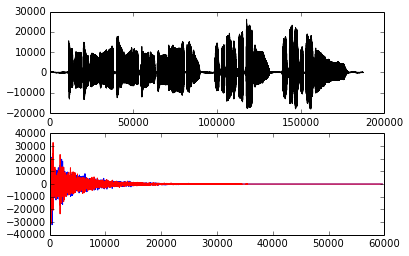

In [179]:
# Visualising the input
%matplotlib inline

plt.subplot(2, 1, 1)
plt.plot(input_sound, 'k')

plt.subplot(2,1, 2)
plt.plot(IR_L, 'b', IR_R, 'r')

In [135]:
# Checking whether the sound and response are compatible
if (sampling_sound == sampling_IR): print "Valid"
else: print "Invalid"

Valid


In [149]:
IR_L = IR[:, 0]
IR_R = IR[:, 1] # Separating the channels of the stereo IR
# Converting the arrays into Python lists
input_sound = list(input_sound)
IR_L = list(IR_L)
IR_R = list(IR_R)

N = len(IR_L) + len(input_sound) # (N-1) is the final length of the convolved signal
print N

246865


In [139]:
# To implement a linear convolution, we extend each of the signals
extend_domain(input_sound, N)
extend_domain(IR_L, N)
extend_domain(IR_R, N)

In [140]:
# We must multiply these signals in the Fourier domain. For this, we convert to NumPy arrays
X = np.asarray(fft_i(input_sound))
IR_l = np.asarray(fft_i(IR_L))
IR_r = np.asarray(fft_i(IR_R))

Y1 = X * IR_l
y1 = ifft_i(Y1)

Y2 = X * IR_r
y2 = ifft_i(Y2)
# Here, we have computed a point-wise multiplication of the signals in the frequency domain
# y1 and y2 refer to the two channels of the sound

In [141]:
# Although we expect zero imaginary part, the approximations and floating-point errors
# may give rise to non-zero imaginary values. Hence discarding.
yr1 = np.real(y1)
yr2 = np.real(y2)

# Normalising the output signal, with room to avoid clipping
yr1 /= max(yr1) * 1.01
yr2 /= max(yr2) * 1.01

# Discarding values after N, since they are arbitrary
# Length of len(y1) = len(x) + len(IR_L) - 1
yr1 = yr1[:(N-1)]
yr2 = yr2[:(N-1)]

In [150]:
# Creating a two-channel sound using the generated channels
yr = np.empty([np.shape(yr1)[0], 2])
yr[:,0] = yr1
yr[:,1] = yr2
print np.shape(yr)

(246864, 2)


In [168]:
# Saving the output file
wavfile.write(result_file, sampling_sound, yr)

In [194]:
print ("Stereo Sound")
display(Audio(result_file))

# print ("Equivalent Output using Scilab 'convol' function")
# display(Audio(dir + "echo_hall_convolved_scilab.wav"))

Stereo Sound


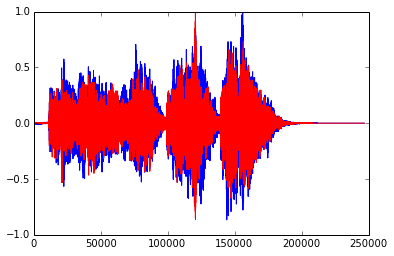

In [195]:
# Visualising the audio signals
%matplotlib inline

plt.plot(yr[:,0], 'b-', yr[:,1], 'r-')

<font size=6><u>Final Remarks and The Road Ahead</u></font>

Clearly, the convolved sound is crisp an sounds better than the one generated by the stock function of Scilab. Where we do lag, is in the implementation time. `Scilab.convol` and `numpy.convol` perform the operation about 10 times faster. Some algorithms might come into picture, and the implementation could be bottom-up traversal etc. The approximations are evident from the presence of stray higher harmonics generated by the `convol` function.

It was a great experience trying to implement and build upon some existing algorithms, and fine-tuning them for our purpose. Taking this forward, we would like to implement the  whole algorithm on a GPU, which could further speed up the process by a factor of $10$ or more.

___Thank You!___